In [1]:
from census import Census
from config_file import (census_key)
import pandas as pd
import geopandas as gpd
import us
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy.stats as st
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Output File (CSV)
output_data_file = "output_data/output.csv"

# Census API Key
c = Census(census_key, year=2016)

# US states abbrv mapping
states = us.states.mapping('abbr', 'name')
states = {state: abbrev for abbrev, state in states.items()}

# Read in police killings csv data
police_killings_df = pd.read_csv('police_killings.csv', dtype={'Zipcode':object})

In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels

#census_data = c.acs5.get(("NAME", "B01003_001E", "B17001_002E"), {'for': 'state:*', 'for':'county:*'})

census_data = c.acs5.get(("B01003_001E", "B17001_002E"), {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Poverty Rate"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Poverty Rate
0,15952,1483.0,14.295347
1,15953,273.0,0.000000
2,15954,2179.0,12.574575
3,15955,2647.0,20.438232
4,15956,2483.0,20.620217


In [3]:
census_data_fips = c.acs5.get(("NAME", "B01003_001E", "B17001_002E"), {'for': 'state:*', 'for':'county:*'})

# Convert to DataFrame
census_fips_pd = pd.DataFrame(census_data_fips)

# Column Reordering
census_fips_pd = census_fips_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name",
                                      "state": "State ID",
                                      "county": "County ID"})

# Add in Poverty Rate (Poverty Count / Population)
census_fips_pd["Poverty Rate"] = 100 * \
    census_fips_pd["Poverty Count"].astype(
        int) / census_fips_pd["Population"].astype(int)

# Final DataFrame
census_fips_pd = census_fips_pd[["Name", "State ID", "County ID", "Population", "Poverty Rate"]]

# Check if any rows with NAN values
census_fips_pd[census_fips_pd.isna().any(axis=1)]

# Drop any rows with NAN
#census_fips_pd = census_fips_pd.dropna(how='any')
census_fips_pd

,Name,State ID,County ID,Population,Poverty Rate
0,"Carroll County, Arkansas",05,015,27690.0,17.295052
1,"Chicot County, Arkansas",05,017,11189.0,29.064260
2,"Clark County, Arkansas",05,019,22684.0,20.992770
3,"Clay County, Arkansas",05,021,15202.0,21.970793
4,"Cleburne County, Arkansas",05,023,25587.0,15.246023
...,...,...,...,...,...
3215,"Manatí Municipio, Puerto Rico",72,091,41468.0,46.110254
3216,"Juana Díaz Municipio, Puerto Rico",72,075,48658.0,47.716717
3217,"Río Grande Municipio, Puerto Rico",72,119,52479.0,36.967168
3218,"Bayamón Municipio, Puerto Rico",72,021,192974.0,34.227927


In [4]:
# Check if any rows with NAN values
census_pd[census_pd.isna().any(axis=1)]

# Drop any rows with NAN
census_pd = census_pd.dropna(how='any')
census_pd

,Zipcode,Population,Poverty Rate
0,15952,1483.0,14.295347
1,15953,273.0,0.000000
2,15954,2179.0,12.574575
3,15955,2647.0,20.438232
4,15956,2483.0,20.620217
...,...,...,...
33115,97760,6458.0,15.082069
33116,97761,4537.0,29.799427
33117,97801,21243.0,14.437697
33118,97810,758.0,11.345646


In [5]:
# Data Cleanup
def get_county(address):
    county = address.split("County")[0].strip(" ")
    county = strip_borough(county)
    county = strip_census_area(county)
    county = strip_municipality(county)
    county = strip_parish(county)
    county = strip_state(county)
    return county

def strip_borough(address):
    return address.split("Borough")[0].strip(" ")

def strip_census_area(address):
    return address.split("Census")[0].strip(" ")

def strip_municipality(address):
    return address.split("Municipality")[0].strip(" ")

def strip_parish(address):
    return address.split("Parish")[0].strip(" ")

def strip_state(address):
    return address.split(",")[0].strip(" ")

def get_state(address):
    state = address.split(",")[1]
    # Special case for District of Columbia
    state = state[1:]
    return state

census_fips_pd['County'] = census_fips_pd['Name'].apply(lambda x: f"{get_county(x)}")
census_fips_pd['State Name'] = census_fips_pd['Name'].apply(lambda x: f"{get_state(x)}")

#Drop PR
indicesPR = census_fips_pd.index[census_fips_pd['State ID'] == '72' ].tolist()
census_fips_pd.drop(indicesPR, inplace=True)

# Get state abbreviations
census_fips_pd['State'] = census_fips_pd['State Name'].map(states)

census_clean_pd = census_fips_pd.drop(['Name', 'State Name'], inplace=False, axis = 1)

census_clean_pd = census_clean_pd[["State", "State ID", "County", "County ID", "Population", "Poverty Rate"]]

# Export into a csv
census_clean_pd.to_csv(output_data_file, index=False)

census_clean_pd['FIPS'] = census_clean_pd['State ID'] + census_clean_pd['County ID']

census_clean_pd

,State,State ID,County,County ID,Population,Poverty Rate,FIPS
0,AR,05,Carroll,015,27690.0,17.295052,05015
1,AR,05,Chicot,017,11189.0,29.064260,05017
2,AR,05,Clark,019,22684.0,20.992770,05019
3,AR,05,Clay,021,15202.0,21.970793,05021
4,AR,05,Cleburne,023,25587.0,15.246023,05023
...,...,...,...,...,...,...,...
3137,WY,56,Sweetwater,037,44812.0,10.863162,56037
3138,WY,56,Teton,039,22623.0,7.293462,56039
3139,WY,56,Uinta,041,20893.0,16.570143,56041
3140,WY,56,Washakie,043,8351.0,14.345587,56043


In [6]:
shp_data = gpd.read_file('zip:///Users/enrightm/Documents/DA.BootCamp/7 - Project-1/Project1/TRACT/tl_2019_01_tract.zip!tl_2019_01_tract.shp')
shp_data.head()
#data.plot()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,055,010700,01055010700,107,Census Tract 107,G5020,S,87404337,2927199,+34.0726595,-085.8991944,"POLYGON ((-85.98698899999999 34.044135, -85.98..."
1,01,055,001300,01055001300,13,Census Tract 13,G5020,S,5083957,836213,+34.0078782,-085.9865947,"POLYGON ((-86.00068499999999 34.00537, -86.000..."
2,01,055,000900,01055000900,9,Census Tract 9,G5020,S,11932347,740907,+34.0003469,-086.0427603,"POLYGON ((-86.070786 34.00011, -86.070756 34.0..."
3,01,055,001700,01055001700,17,Census Tract 17,G5020,S,9118882,0,+33.9825311,-085.9518384,"POLYGON ((-85.968853 33.988255, -85.968841 33...."
4,01,055,010501,01055010501,105.01,Census Tract 105.01,G5020,S,50209675,7198559,+33.8992688,-086.0295803,"POLYGON ((-86.073521 33.905492, -86.0733729999..."


In [7]:
shp_data['FIPS'] = shp_data['STATEFP'] + shp_data['COUNTYFP']
shp_data_clean = shp_data.drop(shp_data.iloc[:, 2:13], inplace = False, axis = 1)
shp_data_clean

,STATEFP,COUNTYFP,FIPS
0,01,055,01055
1,01,055,01055
2,01,055,01055
3,01,055,01055
4,01,055,01055
...,...,...,...
1176,01,077,01077
1177,01,077,01077
1178,01,077,01077
1179,01,119,01119


In [8]:
killings_df = police_killings_df.drop(police_killings_df.iloc[:, 11:], inplace = False, axis = 1) 
killings_df.drop(['URL of image of victim'], inplace=True, axis = 1)
killings_df

,Victim's name,Victim's age,Victim's gender,Victim's race,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,County
0,Adrian Devon Herron,30,Male,Black,16-08-18,2760 N Bonnie Belle Circle,Wasilla,AK,99654,Matanuska-Susitna
1,Benjamin Zekovic,23,Male,White,12/7/2016,400 Rodeo Pl,Anchorage,AK,99508,Anchorage
2,Bishar Hassan,31,Male,Black,1/4/2019,16th Ave and A St,Anchorage,AK,99501,Anchorage
3,Cameron McCarthy,20,Male,White,22-11-18,918 S Colony Way,Palmer,AK,99645,Matanuska-Susitna
4,Carl Bowie III,25,Male,White,19-02-13,53rd Avenue and Windflower Street,Anchorage,AK,99507,Anchorage
...,...,...,...,...,...,...,...,...,...,...
7658,Robbie Edison,47,Male,White,23-07-15,Anderson Dairy Rd,Douglas,WY,82633,Converse
7659,Robert Michael “Robbie” Ramirez,39,Male,Hispanic,4/11/2018,2100 Garfield St,Laramie,WY,82070,Albany
7660,Saige Hack,23,Male,Native American,16-07-15,200 Stinson Ave,Cheyenne,WY,82007,Laramie
7661,Scott Addison,49,Male,White,6/12/2017,Dell Range Blvd and Ridge Rd,Cheyenne,WY,82001,Laramie


In [9]:
killings_clean = killings_df.drop(killings_df.iloc[:, 0:6], inplace = False, axis = 1)

# Check if any rows with NAN values
#killings_clean[killings_clean.isna().any(axis=1)]

# Drop any rows with NAN
killings_clean = killings_clean.dropna(how='any')
killings_clean

,City,State,Zipcode,County
0,Wasilla,AK,99654,Matanuska-Susitna
1,Anchorage,AK,99508,Anchorage
2,Anchorage,AK,99501,Anchorage
3,Palmer,AK,99645,Matanuska-Susitna
4,Anchorage,AK,99507,Anchorage
...,...,...,...,...
7658,Douglas,WY,82633,Converse
7659,Laramie,WY,82070,Albany
7660,Cheyenne,WY,82007,Laramie
7661,Cheyenne,WY,82001,Laramie


In [10]:
# Merge the two data sets along zip code
poverty_killings_combined = pd.merge(
    killings_clean, census_pd, how='inner', on=['Zipcode', 'Zipcode'])

poverty_killings_combined

# Merge the two data sets on county and state for FIPS data set
poverty_killings_fips = pd.merge(
    killings_clean, census_clean_pd, how='inner', on=['State', 'County'])

poverty_killings_combined

,City,State,Zipcode,County,Population,Poverty Rate
0,Wasilla,AK,99654,Matanuska-Susitna,58889.0,9.225832
1,Wasilla,AK,99654,Matanuska-Susitna,58889.0,9.225832
2,Big Lake,AK,99654,Matanuska-Susitna,58889.0,9.225832
3,Wasilla,AK,99654,Matanuska-Susitna,58889.0,9.225832
4,Houston,AK,99654,Matanuska-Susitna,58889.0,9.225832
...,...,...,...,...,...,...
7338,Ethete,WY,82520,Fremont,14012.0,13.160148
7339,Evanston,WY,82930,Uinta,14558.0,19.302102
7340,Gillette,WY,82716,Campbell,18147.0,9.136496
7341,Cheyenne,WY,82007,Laramie,19988.0,18.591155


In [11]:
poverty_killings_fips

,City,State,Zipcode,County,State ID,County ID,Population,Poverty Rate,FIPS
0,Wasilla,AK,99654,Matanuska-Susitna,02,170,98679.0,9.475167,02170
1,Palmer,AK,99645,Matanuska-Susitna,02,170,98679.0,9.475167,02170
2,Wasilla,AK,99654,Matanuska-Susitna,02,170,98679.0,9.475167,02170
3,Big Lake,AK,99654,Matanuska-Susitna,02,170,98679.0,9.475167,02170
4,Palmer,AK,99645,Matanuska-Susitna,02,170,98679.0,9.475167,02170
...,...,...,...,...,...,...,...,...,...
7448,Rawlins,WY,82301,Carbon,56,007,15696.0,13.589450,56007
7449,Evanston,WY,82930,Uinta,56,041,20893.0,16.570143,56041
7450,Gillette,WY,82716,Campbell,56,005,48473.0,8.041590,56005
7451,Cheyenne,WY,82007,Laramie,56,021,96459.0,10.172198,56021


In [12]:
# Poverty killings by FIPS
fips_grp = poverty_killings_fips.groupby('FIPS').size().to_frame('Police Killings')
fips_grp_df = pd.DataFrame(fips_grp).reset_index()
fips_grp_df

fips_cnt_df = pd.merge(fips_grp_df, census_clean_pd, how='inner', on=['FIPS', 'FIPS'])
fips_cnt_df

,FIPS,Police Killings,State,State ID,County,County ID,Population,Poverty Rate
0,01003,6,AL,01,Baldwin,003,199510.0,12.806877
1,01005,2,AL,01,Barbour,005,26614.0,23.427519
2,01009,2,AL,01,Blount,009,57704.0,16.361084
3,01015,9,AL,01,Calhoun,015,115883.0,19.101162
4,01021,2,AL,01,Chilton,021,43817.0,20.035603
...,...,...,...,...,...,...,...,...
1504,56009,2,WY,56,Converse,009,14223.0,8.282360
1505,56013,3,WY,56,Fremont,013,40683.0,13.728093
1506,56021,2,WY,56,Laramie,021,96459.0,10.172198
1507,56025,6,WY,56,Natrona,025,80871.0,10.304064


In [13]:
# State Grouping for FIPS dataset

mo_fips_df = fips_cnt_df[fips_cnt_df['State'] == 'MO']
mo_fips_df

,FIPS,Police Killings,State,State ID,County,County ID,Population,Poverty Rate
706,29007,1,MO,29,Audrain,007,25868.0,16.209216
707,29009,3,MO,29,Barry,009,35716.0,22.051742
708,29011,1,MO,29,Barton,011,12075.0,22.542443
709,29019,3,MO,29,Boone,019,172773.0,18.209442
710,29021,6,MO,29,Buchanan,021,89415.0,17.504893
711,29023,3,MO,29,Butler,023,42887.0,21.108961
712,29027,1,MO,29,Callaway,027,44693.0,11.979505
713,29031,2,MO,29,Cape Girardeau,031,78089.0,16.949891
714,29037,3,MO,29,Cass,037,101324.0,9.208085
715,29039,1,MO,29,Cedar,039,13932.0,22.760551


In [73]:
# Poverty killings by Zip 
zip_grp = poverty_killings_combined.groupby('Zipcode').size().to_frame('Police Killings')
zip_grp_df = pd.DataFrame(zip_grp).reset_index()

zip_cnt_df = pd.merge(zip_grp_df, census_pd, how='inner', on=['Zipcode', 'Zipcode'])
zip_cnt_df


,Zipcode,Police Killings,Population,Poverty Rate
0,10002,1,78096.0,27.605767
1,10009,1,59799.0,22.523788
2,10014,1,31464.0,5.956013
3,10019,1,39505.0,11.790913
4,10021,1,45261.0,6.727646
...,...,...,...,...
4741,99705,2,23539.0,7.196567
4742,99709,2,32355.0,5.801267
4743,99712,2,12339.0,6.005349
4744,99723,1,4377.0,13.753713


In [74]:
# Filter out killings < 6
filt_gt_6 = zip_cnt_df['Police Killings'] > 6
gt_6_df = zip_cnt_df.loc[filt_gt_6]
gt_6_df

,Zipcode,Police Killings,Population,Poverty Rate
967,32210,7,61973.0,22.004744
1102,33147,9,45676.0,34.289342
2242,59101,8,41284.0,13.651778
2324,60624,7,38134.0,44.608486
2326,60628,8,68077.0,31.108891
3105,77036,8,77770.0,37.302302
3417,80211,7,33258.0,16.777918
3603,85006,9,27804.0,44.249029
3605,85008,7,59490.0,32.131451
3606,85009,10,46006.0,45.481024


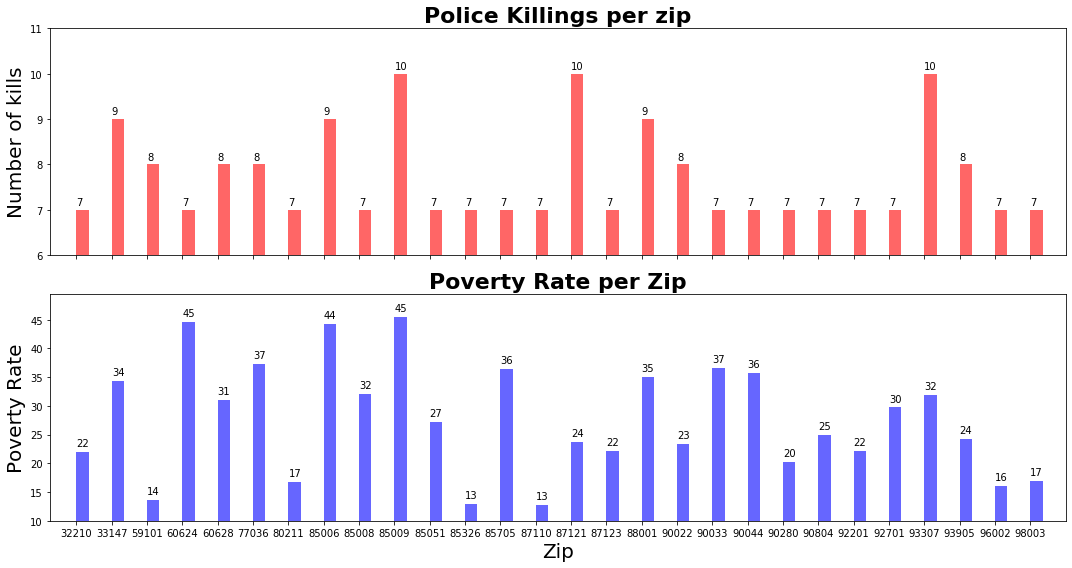

In [75]:
num_kills = gt_6_df['Police Killings']
poverty_rate = gt_6_df['Poverty Rate']
per_zip = gt_6_df['Zipcode']

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,8))
ax1.bar(per_zip, num_kills, color='r', alpha=0.6, align='edge', width=0.35)
ax2.bar(per_zip, poverty_rate, color='b', alpha=0.6, align='edge', width=0.35)

ax1.set_ylim(6, max(num_kills)+1)
ax1.set_title('Police Killings per zip', fontweight="bold", size=22)
ax1.set_ylabel('Number of kills', fontsize = 20)

ax2.set_ylim(10, max(poverty_rate)+4)
ax2.set_title('Poverty Rate per Zip', fontweight="bold", size=22)
ax2.set_xlabel('Zip', fontsize = 20)
ax2.set_ylabel('Poverty Rate', fontsize = 20)

for p in ax1.patches:
    percentage ='{:,.0f}'.format(p.get_height())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()
    y=p.get_y()+height+0.1
    ax1.annotate(percentage,(x,y))

for p in ax2.patches:
    percentage ='{:,.0f}'.format(p.get_height())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()
    y=p.get_y()+height+1
    ax2.annotate(percentage,(x,y))

plt.xlim(-0.75, len(per_zip))
plt.tight_layout()
plt.show()

In [76]:
# Linear regression
def plot_linear_reg(df, title, text_coordinates):
    x_values = df['Poverty Rate']
    y_values = df['Police Killings']
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.title(title)
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,text_coordinates,fontsize=15,color="red")
    plt.xlabel("Poverty Rate")
    plt.ylabel('Police Killings')
    print(f"The r-squared is: {rvalue}")
    plt.show()

The r-squared is: 0.38984045921755134


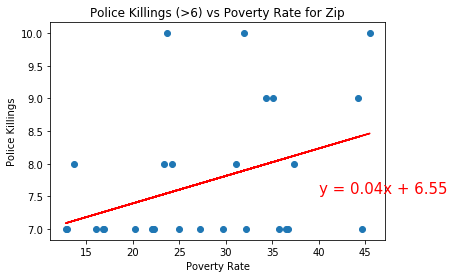

In [77]:
plot_linear_reg(gt_6_df, 'Police Killings (>6) vs Poverty Rate for Zip', (40, 7.55))

The r-squared is: 0.2181852975592446


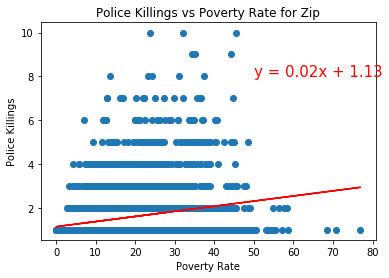

In [78]:
plot_linear_reg(zip_cnt_df, 'Police Killings vs Poverty Rate for Zip', (50, 8))

In [88]:
# Poverty killings in MO
state_df = pd.merge(zip_cnt_df, killings_clean, how='left', on=['Zipcode', 'Zipcode'])

state_df.drop_duplicates(subset ="Zipcode", 
                     keep = 'first', inplace = True)

filt_mo = state_df['State'] == 'MO'
gt_mo_df = state_df.loc[filt_mo]
gt_mo_df['Police Killings'].value_counts()

# Filter out killings < 2
filt_mo_gt = gt_mo_df['Police Killings'] > 1
gt_mo_df = gt_mo_df.loc[filt_mo_gt]
gt_mo_df

,Zipcode,Police Killings,Population,Poverty Rate,City,State,County
3313,63033,2,42434.0,8.797191,Florissant,MO,St. Louis
3322,63106,2,11989.0,54.858620,St. Louis,MO,St. Louis
3324,63107,3,10437.0,43.661972,St. Louis,MO,St. Louis City
3328,63110,2,17423.0,18.050852,St. Louis,MO,St. Louis
3330,63111,3,21380.0,34.162769,St. Louis,MO,St. Louis City
3334,63113,6,11270.0,36.876664,St. Louis,MO,St. Louis City
3341,63115,5,18446.0,32.771333,St. Louis,MO,St. Louis
3346,63116,2,44175.0,21.061686,St. Louis,MO,St. Louis
3349,63118,5,28810.0,34.696286,St. Louis,MO,St. Louis
3354,63121,4,25276.0,22.274094,Pine Lawn,MO,St. Louis


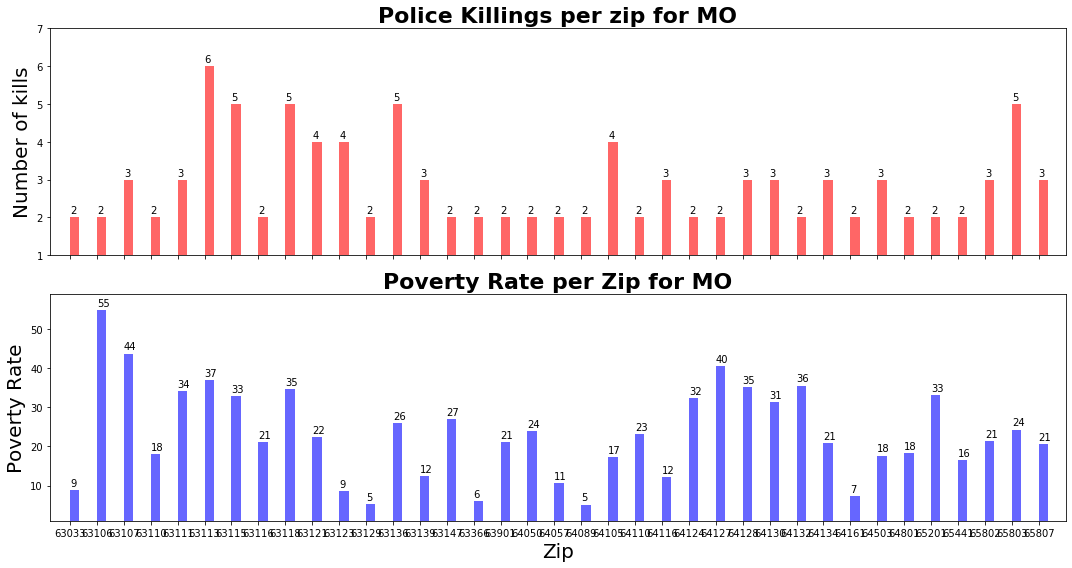

In [92]:
# Bar graph for MO Only
num_kills = gt_mo_df['Police Killings']
poverty_rate = gt_mo_df['Poverty Rate']
per_zip = gt_mo_df['Zipcode']

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,8))
ax1.bar(per_zip, num_kills, color='r', alpha=0.6, align='edge', width=0.35)
ax2.bar(per_zip, poverty_rate, color='b', alpha=0.6, align='edge', width=0.35)

ax1.set_ylim(1, max(num_kills)+1)
ax1.set_title('Police Killings per zip for MO', fontweight="bold", size=22)
ax1.set_ylabel('Number of kills', fontsize = 20)

ax2.set_ylim(1, max(poverty_rate)+4)
ax2.set_title('Poverty Rate per Zip for MO', fontweight="bold", size=22)
ax2.set_xlabel('Zip', fontsize = 20)
ax2.set_ylabel('Poverty Rate', fontsize = 20)

for p in ax1.patches:
    percentage ='{:,.0f}'.format(p.get_height())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()
    y=p.get_y()+height+0.1
    ax1.annotate(percentage,(x,y))

for p in ax2.patches:
    percentage ='{:,.0f}'.format(p.get_height())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()
    y=p.get_y()+height+1
    ax2.annotate(percentage,(x,y))

plt.xlim(-0.75, len(per_zip))
plt.tight_layout()
plt.show()

The r-squared is: 0.21187734134835784


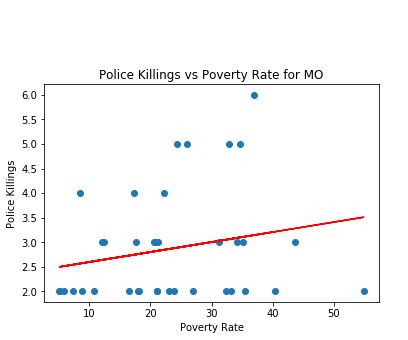

In [94]:
plot_linear_reg(gt_mo_df, 'Police Killings vs Poverty Rate for MO', (40, 7.55))

In [100]:
state_grp = poverty_killings_combined.groupby('State').size().to_frame('Police Killings')
state_grp_df = pd.DataFrame(state_grp).reset_index()

state_cnt_df = pd.merge(state_grp_df, poverty_killings_combined, how='left', on=['State', 'State'])

state_cnt_df = state_cnt_df.groupby('State').mean().reset_index()
state_cnt_df


,State,Police Killings,Population,Poverty Rate
0,AK,40,24138.200000,12.449049
1,AL,138,16654.724638,19.815872
2,AR,103,19523.689320,20.165540
3,AZ,340,36046.002941,22.860055
4,CA,1181,44577.086367,19.573829
5,CO,225,29528.995556,15.850364
6,DC,25,46395.440000,24.885552
7,DE,20,24386.500000,12.039131
8,FL,534,31596.644195,19.209775
9,GA,263,31038.935361,20.578916


In [124]:
fig = go.Figure()
fig.add_trace(go.Choropleth(
    locations=state_cnt_df['State'],
    z=state_cnt_df['Police Killings'].astype(float),
    locationmode='USA-states',
    colorscale=["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1","#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9","#08519c","#0b4083","#08306b"],
    #endpts = list(np.linspace(1, 12, len(colorscale) - 1)),
    #colorscale='YlOrRd',
    autocolorscale=False,
    text=round(state_cnt_df['Poverty Rate'],1), # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="Police Killings",showscale = True
))

fig.update_layout(
    title_text='US Police Killings vs Poverty Rate by State',
    title_x=0.5,
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(155, 255, 255)')
)


fig.update_layout(
    template="plotly_dark",showlegend=False)
fig.show()

In [44]:
values = mo_fips_df['Police Killings'].astype(float)
values2 = mo_fips_df['Poverty Rate'].astype(float)
fips = mo_fips_df['FIPS'].astype(float)
endpts = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
#list(np.mgrid[min(values):max(values):4j])
colorscale=["#c6dbef","#b3d2e9","#9ecae1","#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9","#08519c","#0b4083","#08306b"]
#"#f7fbff","#ebf3fb","#deebf7","#d2e3f3",
#colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
#              "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['Missouri'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
    #plot_bgcolor='rgb(229,229,229)',
    #paper_bgcolor='rgb(229,229,229)',
    #text=round(mo_fips_df['Poverty Rate'],1), # hover text
    legend_title='Police Killings',
    #county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
    exponent_format=True,
    title='Police Killings in Missouri',
    simplify_county=0, simplify_state=0,
    county_outline={'color': 'rgb(15, 15, 55)', 'width': 0.5},
    state_outline={'width': 1},
)
fig.layout.template = None
    
fig.show()

In [45]:
values2 = mo_fips_df['Poverty Rate'].astype(float)
fips = mo_fips_df['FIPS'].astype(float)
endpts = [1, 5, 10, 15, 20, 25, 30]
#list(np.mgrid[min(values):max(values):4j])
colorscale=["#57a0ce","#4292c6","#3082be","#2171b5","#1361a9","#08519c","#0b4083","#08306b"]
#""#c6dbef","#b3d2e9","#9ecae1","#85bcdb","#6baed6","#f7fbff","#ebf3fb","#deebf7","#d2e3f3",
#colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
#              "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
fig = ff.create_choropleth(
    fips=fips, values=values2, scope=['Missouri'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
    #plot_bgcolor='rgb(229,229,229)',
    #paper_bgcolor='rgb(229,229,229)',
    #text=round(mo_fips_df['Poverty Rate'],1), # hover text
    legend_title='Poverty Rate',
    #county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
    exponent_format=True,
    title='Poverty Rate in Missouri',
    simplify_county=0, simplify_state=0,
    county_outline={'color': 'rgb(15, 15, 55)', 'width': 0.5},
    state_outline={'width': 1},
)
fig.layout.template = None
    
fig.show()

In [107]:
lat_lng_df = pd.read_csv('us-zip-code-latitude-and-longitude.csv', dtype={'Zip':object})

lat_lng_df = lat_lng_df[['Zip', 'City', 'Latitude', 'Longitude']]
lat_lng_df.rename(columns = {'Zip': 'Zipcode'}, inplace = True)
lat_lng_df.head()

,Zipcode,City,Latitude,Longitude
0,71937,Cove,34.398483,-94.39398
1,72044,Edgemont,35.624351,-92.16056
2,56171,Sherburn,43.660847,-94.74357
3,49430,Lamont,43.010337,-85.89754
4,52585,Richland,41.194129,-91.98027


In [109]:
ll_pov_df = pd.merge(zip_cnt_df, lat_lng_df, how='inner', on=['Zipcode', 'Zipcode'])
ll_pov_df

,Zipcode,Police Killings,Population,Poverty Rate,City,Latitude,Longitude
0,10002,1,78096.0,27.605767,New York,40.717040,-73.98700
1,10009,1,59799.0,22.523788,New York,40.727093,-73.97864
2,10014,1,31464.0,5.956013,New York,40.734718,-74.00532
3,10019,1,39505.0,11.790913,New York,40.765714,-73.98560
4,10021,1,45261.0,6.727646,New York,40.768420,-73.96045
...,...,...,...,...,...,...,...
4698,99705,2,23539.0,7.196567,North Pole,64.777233,-147.36490
4699,99709,2,32355.0,5.801267,Fairbanks,64.854937,-147.87406
4700,99712,2,12339.0,6.005349,Fairbanks,64.926041,-147.49573
4701,99723,1,4377.0,13.753713,Barrow,71.299525,-156.74891


In [115]:
ll_pov_df['Police Killings'].value_counts()

1     3218
2      871
3      357
4      138
5       63
6       28
7       17
8        5
10       3
9        3
Name: Police Killings, dtype: int64

In [111]:

ll_pov_df['text'] = 'Zip ' + ll_pov_df['Zipcode'] + '<br>Population ' + (ll_pov_df['Population']/1e3).astype(str)+' K' + '<br>Killed ' + (ll_pov_df['Police Killings']).astype(str) + '<br>Poverty Rate ' + (ll_pov_df['Poverty Rate']).astype(str)
limits = [(0,7),(7,23),(23,92),(92,496),(497,4093)]
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
cities = []
scale = 0.05

In [114]:
fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    ll_pov_df_sub = ll_pov_df[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = ll_pov_df_sub['Longitude'],
        lat = ll_pov_df_sub['Latitude'],
        text = ll_pov_df_sub['text'],
        marker = dict(
            size = ll_pov_df_sub['Police Killings']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = 'Fatal Killings by Zip vs Poverty Rate<br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

In [11]:
# Poverty and Killings by State
poverty_killings_state = poverty_killings_state_combined.drop(poverty_killings_combined.iloc[:, 0:6], inplace = False, axis = 1)
poverty_killings_state.drop(['City', 'Zipcode', 'State ID', 'Population'], inplace=True, axis = 1)
poverty_killings_state_gp = poverty_killings_state.groupby(['State'])
poverty_killings_state_df = pd.DataFrame(poverty_killings_state_gp['Poverty Rate'].value_counts())
poverty_killings_state_df.rename(columns = {'Poverty Rate': 'Police Killings'}, inplace = True)
poverty_killings_state_df = poverty_killings_state_df.reset_index()
poverty_killings_state_df.set_index(["State"], inplace = True)

poverty_killings_state_df

,Poverty Rate,Police Killings
State,,
AK,9.883356,41
AL,17.943329,138
AR,18.273071,103
AZ,17.323663,343
CA,15.533257,1186
CO,11.903394,227
CT,10.044781,36
DC,17.004320,26
DE,11.709488,20


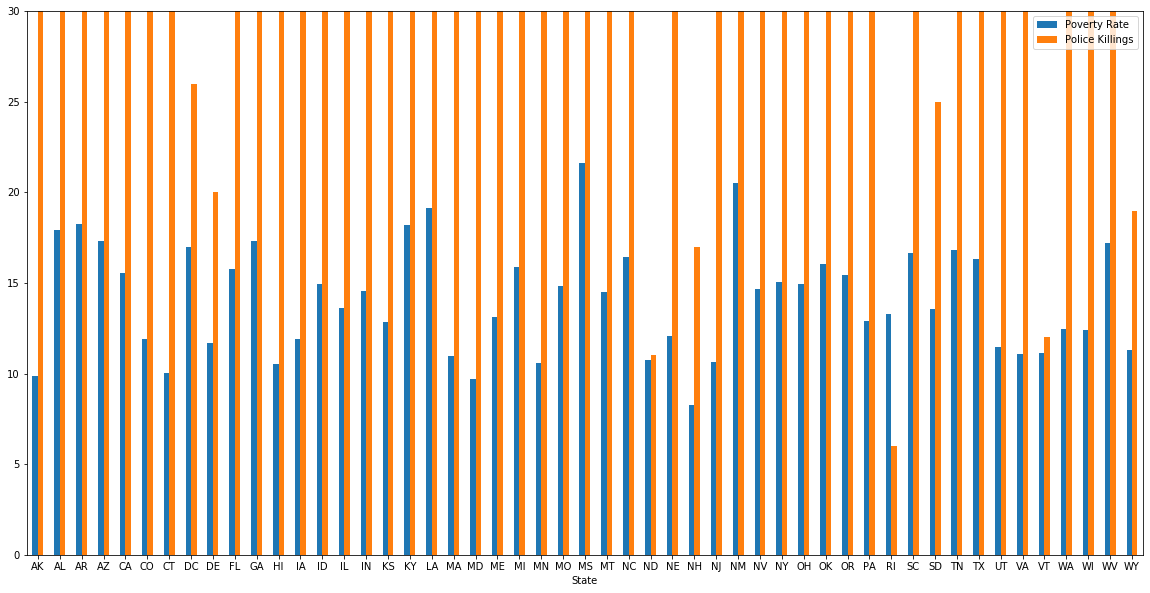

In [18]:
poverty_killings_state_df.plot.bar(rot=0, figsize=(20,10), ylim=(0,30))

#for index, value in enumerate(poverty_killings_state_df['Police Killings']):
#    bargraph.text(value, index, str(value))
    

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025B568255F8>,
      dtype=object)

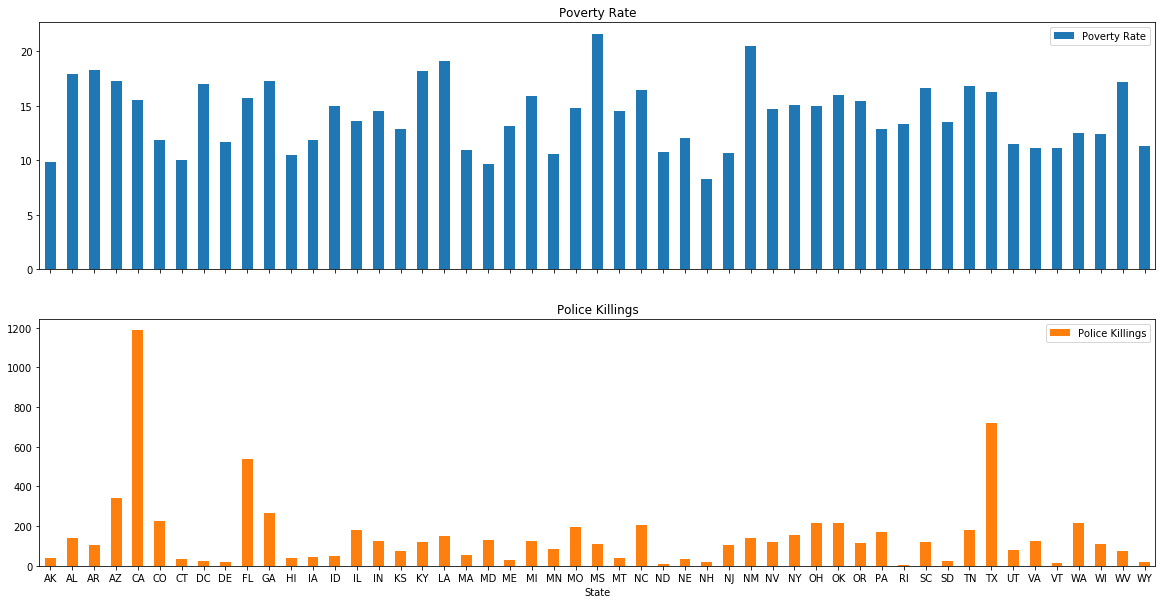

In [20]:
poverty_killings_state_df.plot.bar(rot=0, figsize=(20,10), subplots=True)

In [130]:
# Poverty and Killings by County
poverty_killings_county = poverty_killings_combined.drop(poverty_killings_combined.iloc[:, 0:6], inplace = False, axis = 1)
poverty_killings_county.drop(['City', 'Zipcode', 'State ID', 'County ID', 'Population'], inplace=True, axis = 1)
poverty_killings_county_gp = poverty_killings_county.groupby(['County', 'State'])
#poverty_killings_county['State ID'].value_counts()
poverty_killings_county_gp_df = pd.DataFrame(poverty_killings_county_gp['Poverty Rate'].value_counts())
poverty_killings_county_gp_df.rename(columns = {'Poverty Rate': 'Police Killings'}, inplace = True)
poverty_killings_county_gp_df = poverty_killings_county_gp_df.reset_index()
poverty_killings_county_gp_df.set_index(["County", "State"], inplace = True)
poverty_killings_county_gp_df

# Rename columns
#poverty_killings_county_gp_df(columns = {'Poverty Rate': 'Police Killings'}, inplace = True)

#top_spenders_df.index.name = 'SN'
#poverty_killings_county_df = pd.DataFrame(poverty_killings_county)
#poverty_killings_county_df

Poverty Rate  Police Killings
County State                               
Acadia LA        20.167703                2
Ada    ID        12.001231               12
Adair  OK        29.759487                2
Adams  CO        12.764153               32
       ID        14.514877                1
...                    ...              ...
York   PA        10.238899               11
       SC        12.303445                3
       VA         6.055082                2
Yuba   CA        20.406782                9
Yuma   AZ        19.838459                7

[1512 rows x 2 columns]

In [152]:
# Poverty and Killings by State
poverty_killings_state = poverty_killings_combined.drop(poverty_killings_combined.iloc[:, 0:6], inplace = False, axis = 1)
poverty_killings_state.drop(['City', 'Zipcode', 'State ID', 'County', 'County ID', 'Population'], inplace=True, axis = 1)
poverty_killings_state_gp = poverty_killings_state.groupby(['State'])
#poverty_killings_state.set_index(["State"], inplace = True)
#poverty_killings_state_df = pd.DataFrame(
poverty_killings_state_df = pd.DataFrame(poverty_killings_state_gp['Poverty Rate'].value_counts())
#poverty_killings_state_df.rename(columns = {'Poverty Rate': 'Police Killings'}, inplace = True)
#poverty_killings_state_df = poverty_killings_county_gp_df.reset_index()
poverty_killings_state_df

Poverty Rate
State Poverty Rate              
AK    7.901885                11
      7.432851                10
      9.475167                 9
      10.713604                3
      8.422600                 1
...                          ...
WY    23.971879                2
      8.041590                 1
      11.608415                1
      13.589450                1
      16.570143                1

[1512 rows x 1 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000239764CE390>,
      dtype=object)

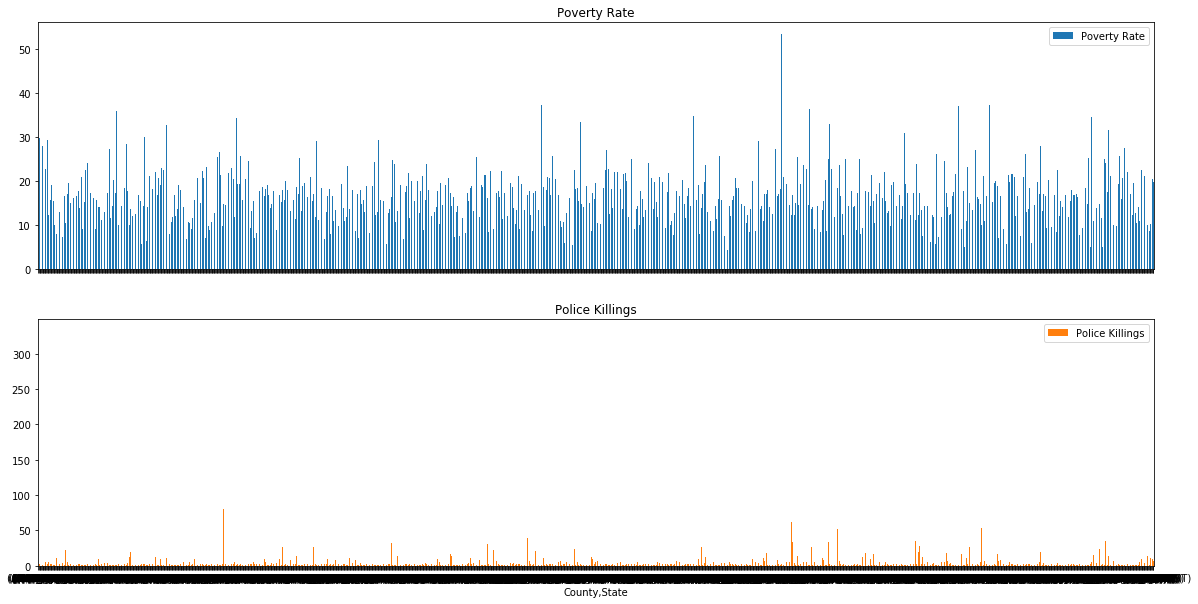

In [138]:
#x_axis = poverty_killings_county_gp_df.index
#df.pivot(poverty_killings_county_gp_df.index, columns=poverty_killings_county_gp_df[, values='booked').plot(kind='bar')
#plt.bar()
                                                                                
#df = pd.DataFrame({'Poverty Rate': poverty_killings_county_gp_df['Poverty Rate'],
#                   'Police Killings': poverty_killings_county_gp_df['Police Killings']}, poverty_killings_county_gp_df.index)
poverty_killings_county_gp_df.plot.bar(rot=0, figsize=(20,10), subplots=True)

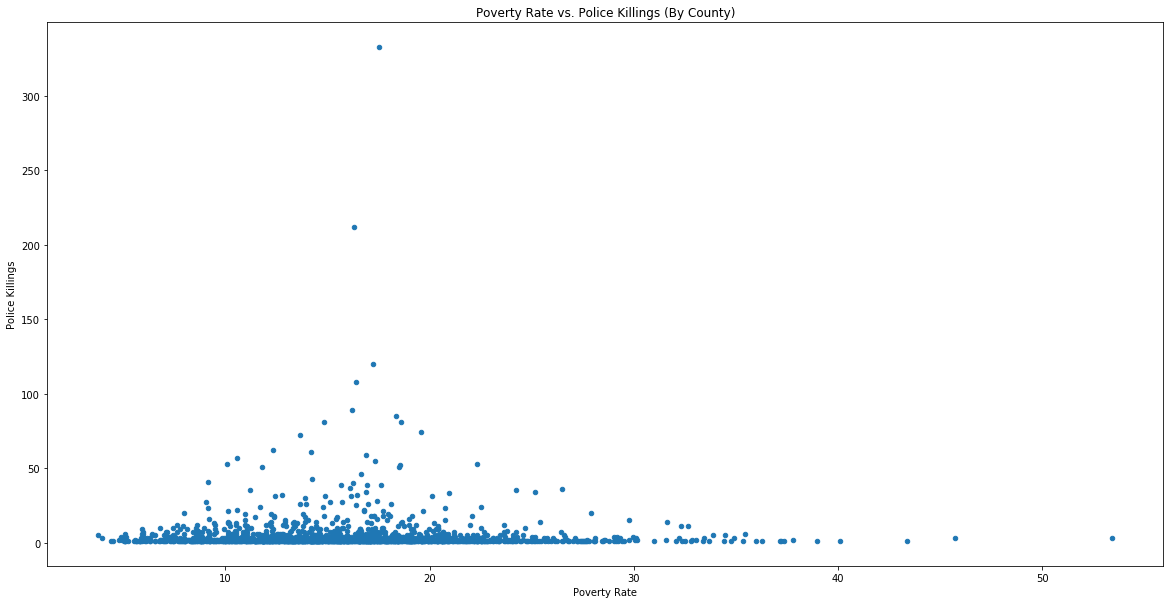

In [141]:
poverty_killings_county_gp_df.plot.scatter(x='Poverty Rate',
                      y='Police Killings',
                      title='Poverty Rate vs. Police Killings (By County)',
                      figsize=(20,10))

In [ ]:
df.dropna()
df.drop()
df.rename()
df.replace()
